In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import joblib
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd

np.random.seed(42)

In [2]:
loaded = np.load("../../Data/Data/data_x.npz", allow_pickle=True)
dict_x = {key: loaded[key] for key in loaded.files}

loaded = np.load("../../Data/Data/data_y.npz", allow_pickle=True)
dict_y = {key: loaded[key] for key in loaded.files}

In [3]:
years = np.array(range(2012, 2024))

In [4]:
def data_by_year(dict_x, dict_y):
    all_keys = list(dict_x.keys())
    data_by_year_x = []
    data_by_year_y = []

    for y in range(len(years)):
        data_year_x = []
        data_year_y = []
        for id in all_keys:
            data_year_x.append(dict_x[id][y])
            data_year_y.append(dict_y[id][y])
        tensor_x = torch.tensor(np.stack(data_year_x), dtype=torch.float32)
        tensor_y = torch.tensor(np.array(data_year_y), dtype=torch.float32).unsqueeze(1)
        data_by_year_x.append(tensor_x)
        data_by_year_y.append(tensor_y)

    print(len(data_by_year_x), data_by_year_x[0].shape)
    print(len(data_by_year_y), data_by_year_y[0].shape)

    return (data_by_year_x, data_by_year_y)

In [5]:
def data_by_county(dict_x, dict_y):
    all_keys = list(dict_x.keys())
    data_by_county_x = []
    data_by_county_y = []

    for id in all_keys:
        tensor_x = torch.tensor(dict_x[id], dtype=torch.float32)
        tensor_y = torch.tensor(dict_y[id], dtype=torch.float32).unsqueeze(1)
        data_by_county_x.append(tensor_x)
        data_by_county_y.append(tensor_y)

    print(len(data_by_county_x), data_by_county_x[0].shape)
    print(len(data_by_county_y), data_by_county_y[0].shape)

    return (data_by_county_x, data_by_county_y)

In [6]:
class RNN_Regressor(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()

        lstm_hidden_size = 32
        hidden_size = 4

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=lstm_hidden_size, batch_first=True)

        self.dense1 = nn.Linear(lstm_hidden_size, hidden_size)
        self.dense2 = nn.Linear(hidden_size, output_size)

        

    def forward(self, input):
        x = F.dropout(input, p=0.35, training=self.training)

        x, _ = self.lstm(x)
        x = x[:, -1, :]

        x = self.dense1(x)
        x = F.leaky_relu(x)

        x = self.dense2(x)
        x = F.sigmoid(x)

        return x

In [7]:
data_by_year_x, data_by_year_y = data_by_year(dict_x, dict_y)
data_by_county_x, data_by_county_y = data_by_county(dict_x, dict_y)

12 torch.Size([3096, 3, 73])
12 torch.Size([3096, 1])
3096 torch.Size([12, 3, 73])
3096 torch.Size([12, 1])


In [8]:
scaler_y = joblib.load("../../Data/Data/scaler_y.pkl")

model = RNN_Regressor(data_by_year_x[0].shape[2], 1)
incompat  = model.load_state_dict(torch.load("../../Model/Model/model.pt"))
model.eval()

RNN_Regressor(
  (lstm): LSTM(73, 32, batch_first=True)
  (dense1): Linear(in_features=32, out_features=4, bias=True)
  (dense2): Linear(in_features=4, out_features=1, bias=True)
)

In [9]:
def scorer(data_by_x, data_by_y):
    mean_output_list = []
    mean_data_y_list = []
    mean_diffrence_list = []
    r2_list = []
    mae_list = []
    std_list = []

    for data_x, data_y in zip(data_by_x, data_by_y):
        with torch.no_grad(): 
            output = model(data_x)
            output = scaler_y.inverse_transform(output)
            data_y = scaler_y.inverse_transform(data_y)
            errors = data_y - output

            mean_output_list.append(np.mean(output))
            mean_data_y_list.append(np.mean(data_y))
            mean_diffrence_list.append(np.mean(errors))

            r2_list.append(r2_score(data_y, output))

            mae_list.append(np.mean(np.abs(errors)))
            std_list.append(np.std(np.abs(errors), ddof=1))

    mean_output_list = np.array(mean_output_list).flatten()
    mean_data_y_list = np.array(mean_data_y_list).flatten()
    mean_diffrence_list = np.array(mean_diffrence_list).flatten()
    r2_list = np.array(r2_list).flatten()
    mae_list = np.array(mae_list).flatten()
    std_list = np.array(std_list).flatten()
    
    return (mean_output_list, mean_data_y_list, mean_diffrence_list, r2_list, mae_list, std_list)

In [10]:
mean_output_by_year, mean_data_y_by_year, mean_diffrence_by_year, r2_by_year, mae_by_year, std_by_year = scorer(data_by_year_x, data_by_year_y)
mean_output_by_county, mean_data_y_by_county, mean_diffrence_by_county, r2_by_county, mae_by_county, std_by_county = scorer(data_by_county_x, data_by_county_y)

In [11]:
with torch.no_grad(): 
    output_by_2021 = scaler_y.inverse_transform(model(data_by_year_x[9])).flatten()
    data_y_by_2021 = scaler_y.inverse_transform(data_by_year_y[9]).flatten()

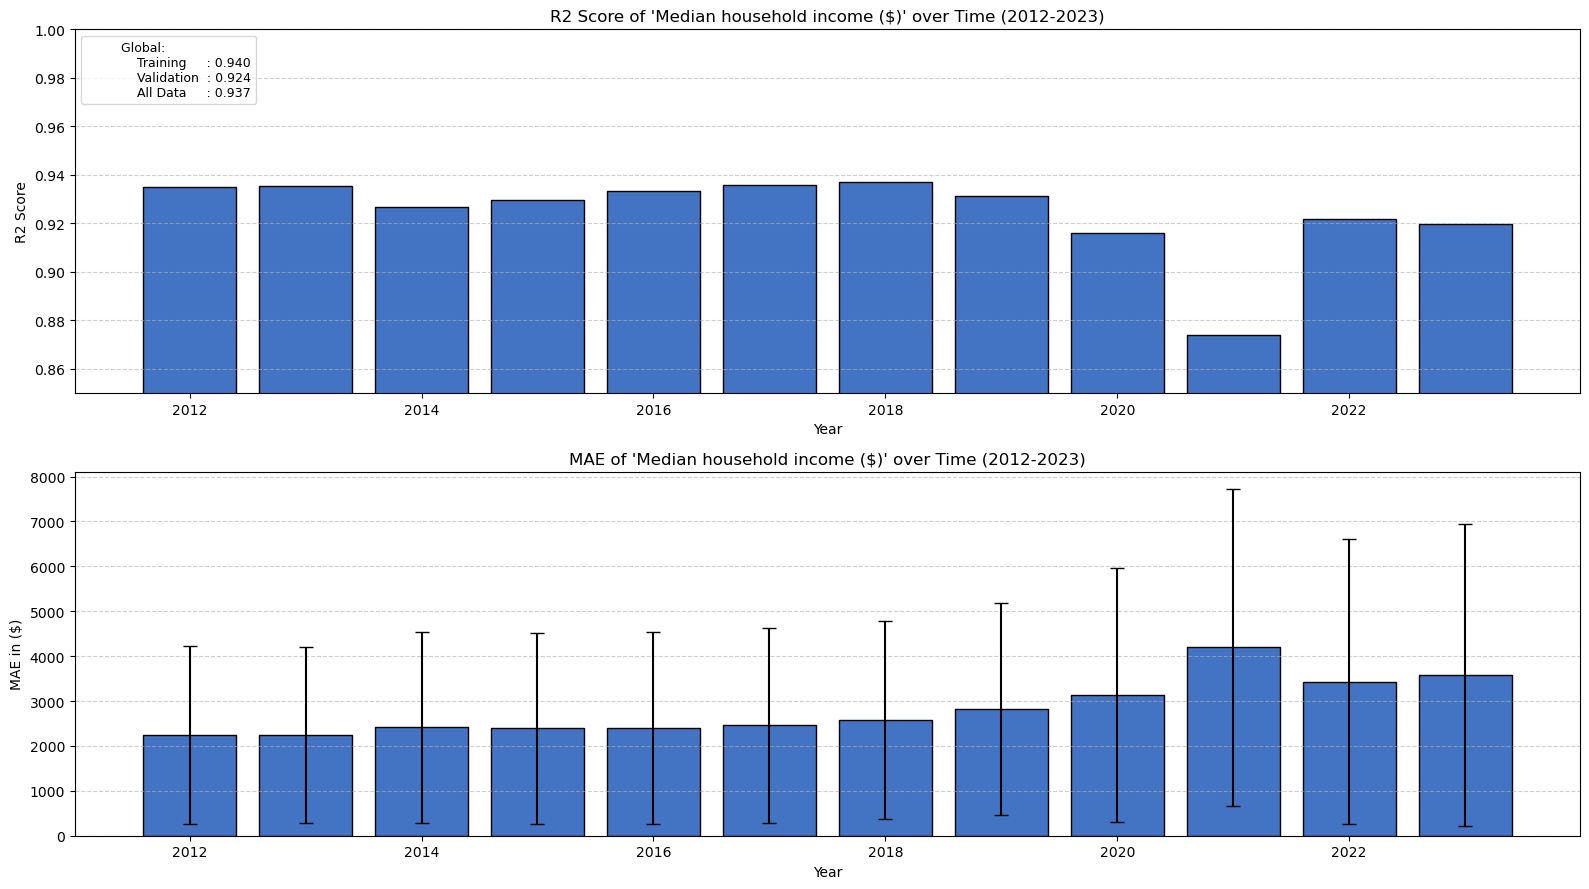

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(16, 9))
ax = ax.flatten()

ax[0].bar(years, r2_by_year, capsize=5, color="#4373c3", edgecolor="black")
ax[1].bar(years, mae_by_year, yerr=std_by_year, capsize=5, color="#4373c3", edgecolor="black")

ax[0].set_ylim(0.85, 1.0)

ax[0].grid(True, axis='y', linestyle='--', alpha=0.6)
ax[1].grid(True, axis='y', linestyle='--', alpha=0.6)

ax[0].set_title("R2 Score of 'Median household income ($)' over Time (2012-2023)")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("R2 Score")

ax[1].set_title("MAE of 'Median household income ($)' over Time (2012-2023)")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("MAE in ($)")

label_0 = "Global: \n" \
          "    Training     : 0.940\n" \
          "    Validation  : 0.924\n " \
          "   All Data     : 0.937"
        

patch = mpatches.Patch(color='none', label=label_0)
ax[0].legend(handles=[patch], loc='upper left', fontsize=9)

fig.tight_layout()

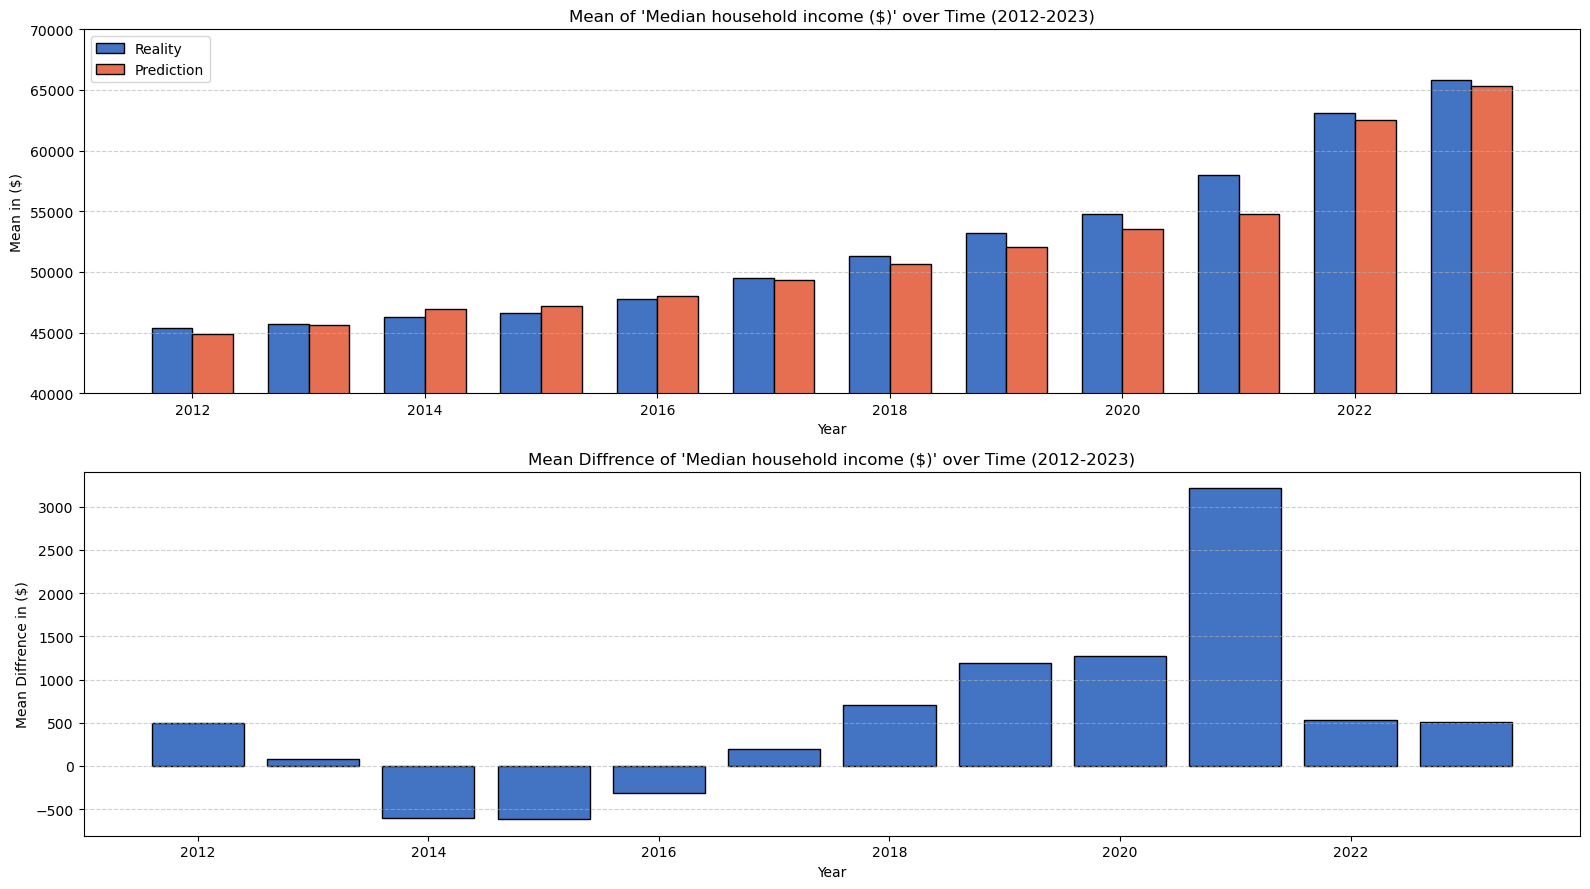

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(16, 9))
ax = ax.flatten()

width = 0.35

ax[0].bar(years - width/2, mean_data_y_by_year, width, label='Reality', color='#4373c3', edgecolor="black")
ax[0].bar(years + width/2, mean_output_by_year, width, label='Prediction', color='#e76f51', edgecolor="black")
ax[0].legend(loc='upper left')

ax[1].bar(years, mean_diffrence_by_year, color='#4373c3', edgecolor="black")

ax[0].grid(True, axis='y', linestyle='--', alpha=0.6)
ax[1].grid(True, axis='y', linestyle='--', alpha=0.6)

ax[0].set_ylim(40000, 70000)

ax[0].set_title("Mean of 'Median household income ($)' over Time (2012-2023)")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Mean in ($)")

ax[1].set_title("Mean Diffrence of 'Median household income ($)' over Time (2012-2023)")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Mean Diffrence in ($)")

fig.tight_layout()

In [14]:
gdf = gpd.read_file("../../Data/Shapefiles/tl_2023_us_county.shp")
gdf = gdf[["GEOIDFQ", "geometry"]]

geoid_order = list(dict_x.keys())
geoid_index = {geoid: index for index, geoid in enumerate(geoid_order)}

In [15]:
gdf_filtered = gdf[gdf['GEOIDFQ'].isin(geoid_order)].copy()
gdf_filtered['GEOIDFQ_rank'] = gdf_filtered['GEOIDFQ'].map(geoid_index)

gdf_sorted = gdf_filtered.sort_values('GEOIDFQ_rank')

In [16]:
new_col = ["mae", "std", 'dat', 'out', 'dat 2021', 'out 2021']

gdf_sorted['mae'] = mae_by_county
gdf_sorted['std'] = std_by_county
gdf_sorted['dat'] = mean_data_y_by_county
gdf_sorted['out'] = mean_output_by_county

gdf_sorted['dat 2021'] = data_y_by_2021
gdf_sorted['out 2021'] = output_by_2021

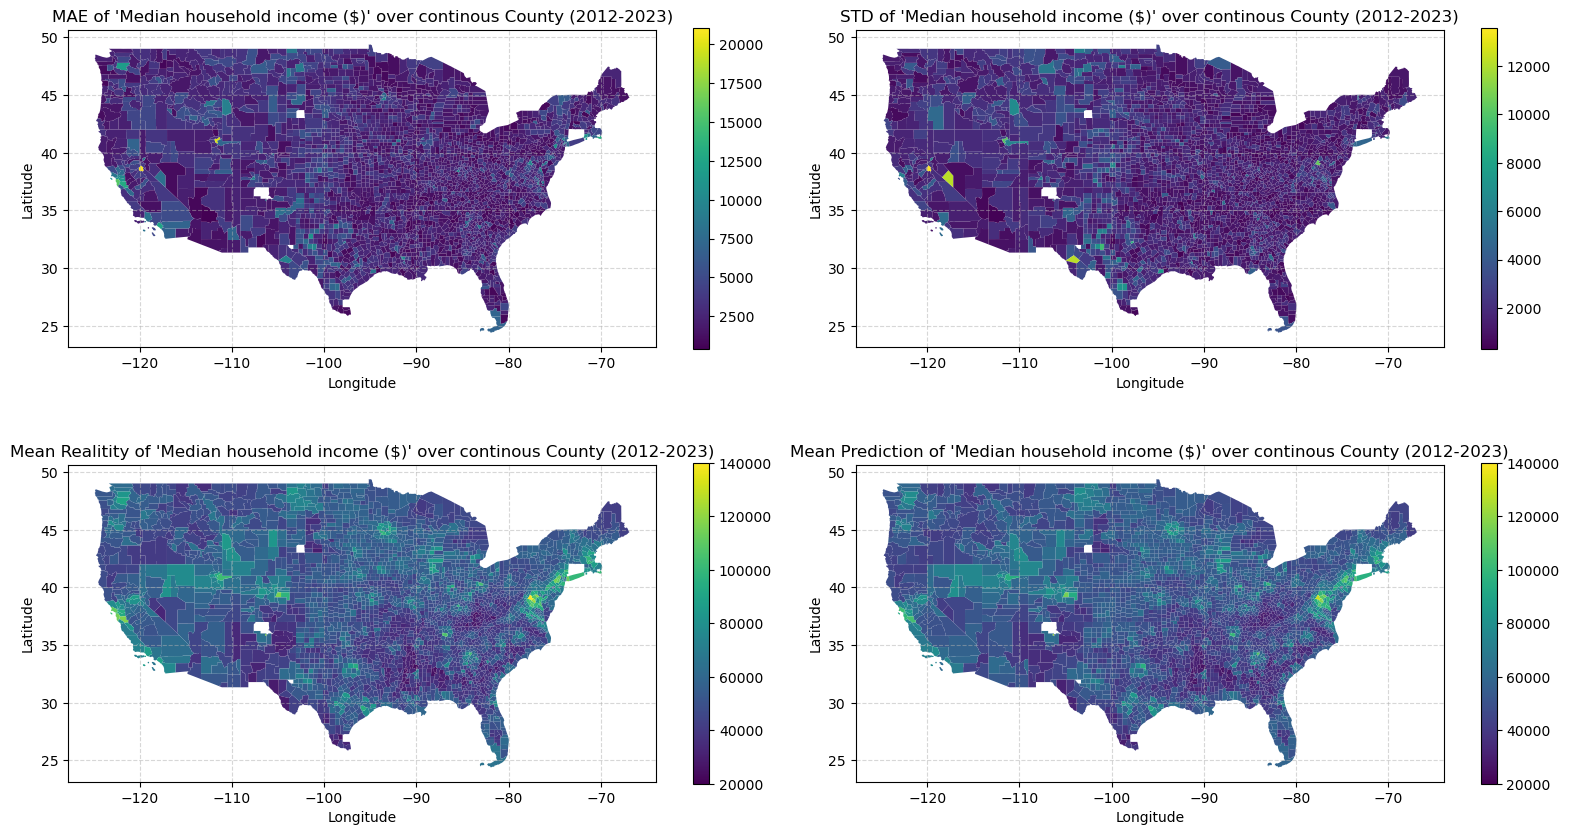

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(16, 9))
ax = ax.flatten()

gdf_sorted.plot(column=new_col[0], cmap="viridis", legend=True, ax=ax[0], legend_kwds={'shrink': 0.75})
gdf_sorted.plot(column=new_col[1], cmap="viridis", legend=True, ax=ax[1], legend_kwds={'shrink': 0.75})
gdf_sorted.plot(column=new_col[2], cmap="viridis", legend=True, ax=ax[2], legend_kwds={'shrink': 0.75}, vmin=20_000, vmax=140_000)
gdf_sorted.plot(column=new_col[3], cmap="viridis", legend=True, ax=ax[3], legend_kwds={'shrink': 0.75}, vmin=20_000, vmax=140_000)

ax[0].set_title("MAE of 'Median household income ($)' over continous County (2012-2023)")
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")

ax[1].set_title("STD of 'Median household income ($)' over continous County (2012-2023)")
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")

ax[2].set_title("Mean Realitity of 'Median household income ($)' over continous County (2012-2023)")
ax[2].set_xlabel("Longitude")
ax[2].set_ylabel("Latitude")

ax[3].set_title("Mean Prediction of 'Median household income ($)' over continous County (2012-2023)")
ax[3].set_xlabel("Longitude")
ax[3].set_ylabel("Latitude")

ax[0].grid(True, linestyle='--', alpha=0.5)
ax[1].grid(True, linestyle='--', alpha=0.5)
ax[2].grid(True, linestyle='--', alpha=0.5)
ax[3].grid(True, linestyle='--', alpha=0.5)

fig.tight_layout()

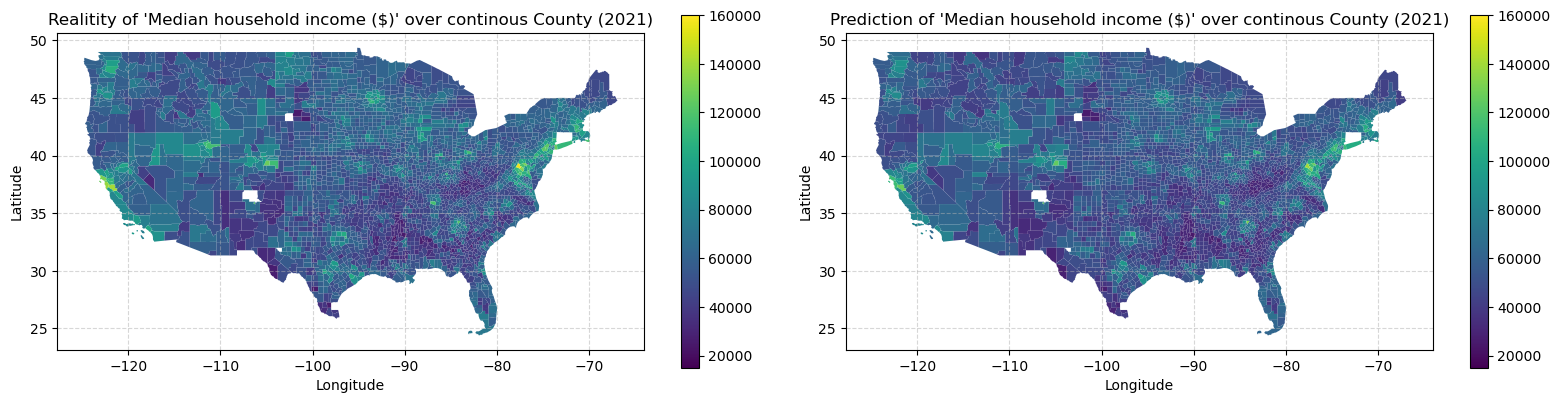

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
ax = ax.flatten()

gdf_sorted.plot(column=new_col[4], cmap="viridis", legend=True, ax=ax[0], legend_kwds={'shrink': 0.75}, vmin=15_000, vmax=160_000)
gdf_sorted.plot(column=new_col[5], cmap="viridis", legend=True, ax=ax[1], legend_kwds={'shrink': 0.75}, vmin=15_000, vmax=160_000)

ax[0].set_title("Realitity of 'Median household income ($)' over continous County (2021)")
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")

ax[1].set_title("Prediction of 'Median household income ($)' over continous County (2021)")
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")

ax[0].grid(True, linestyle='--', alpha=0.5)
ax[1].grid(True, linestyle='--', alpha=0.5)

fig.tight_layout()